# Detecção de Outliers nas Cotas Parlamentares

Primeiro, vamos investigar manualmente alguns gastos dos deputados em 2015. Em seguida, usaremos uma técnica simples de Aprendizado de Máquina (_Machine Learning_) para buscar transações incomuns por todos os dados.

## O que é a Cota para Exercício da Atividade Parlamentar (CEAP)?

É um valor mensal recebido, além do salário, para custear os gastos dos deputados na atividade parlamentar. Em 2016, esse valor varia entre R\$ 30.788,66 para deputados do DF e R\$ 44.632,46 para os do Acre. Ainda há um adicional de R\$ 1.353,04 em alguns casos. Mais detalhes na [assessoria de imprensa da Câmara dos Deputados](http://www2.camara.leg.br/comunicacao/assessoria-de-imprensa/cota-parlamentar).

## Conhecendo os dados

Vamos carregar os dados de 2015 e olhar a primeira entrada. Os dados utilizados estão no formato CSV e foram convertidos do [original em XML](http://www2.camara.leg.br/transparencia/cota-para-exercicio-da-atividade-parlamentar/dados-abertos-cota-parlamentar). O significado de cada coluna pode ser conferido no [site de transparência da Câmara](http://www2.camara.leg.br/transparencia/cota-para-exercicio-da-atividade-parlamentar/explicacoes-sobre-o-formato-dos-arquivos-xml).

In [1]:
import pandas as pd
ceap = pd.read_csv('dados/ceap2015.csv.zip')

In [2]:
linhas, colunas = ceap.shape
print('Temos {} entradas com {} colunas cada.'.format(linhas, colunas))
print('Primeira entrada:')
ceap.iloc[0]

Temos 368802 entradas com 29 colunas cada.
Primeira entrada:


codLegislatura                                                              55
datEmissao                                                 2015-11-14T00:00:00
ideCadastro                                                             178957
ideDocumento                                                       5.88634e+06
indTipoDocumento                                                             0
nuCarteiraParlamentar                                                        1
nuDeputadoId                                                              3074
nuLegislatura                                                             2015
numAno                                                                    2015
numEspecificacaoSubCota                                                      0
numLote                                                                1255355
numMes                                                                      11
numParcela                                          

## Análise manual

Por curiosidade, vamos calcular quais foram os 3 parlamentares que mais gastaram em 2015:

In [3]:
colunas = ['txNomeParlamentar', 'sgPartido', 'sgUF', 'vlrLiquido']
grupo = ['txNomeParlamentar', 'sgPartido', 'sgUF']
ceap[colunas].groupby(grupo).sum().sort_values('vlrLiquido', ascending=False).head(3)

,,,vlrLiquido
txNomeParlamentar,sgPartido,sgUF,
JHONATAN DE JESUS,PRB,RR,516027.24
MARCOS ROGÉRIO,DEM,RO,509794.22
SHÉRIDAN,PSDB,RR,503166.82


O deputado que mais usou a cota parlamentar totalizou R\$ 516.027,24 em 2015, uma média de um pouco mais que R$ 43.000,00 mensais. Caso tenha lembrado dos valores, ele é sim do Acre, Boa Vista. Vamos verificar seu maior gasto:

In [4]:
nome = "JHONATAN DE JESUS"
ceap[ceap.txNomeParlamentar == nome].sort_values('vlrLiquido', ascending=False).iloc[0]

codLegislatura                                                 55
datEmissao                                    2015-10-01T00:00:00
ideCadastro                                                160531
ideDocumento                                          5.81811e+06
indTipoDocumento                                                0
nuCarteiraParlamentar                                           5
nuDeputadoId                                                 2333
nuLegislatura                                                2015
numAno                                                       2015
numEspecificacaoSubCota                                         0
numLote                                                   1234143
numMes                                                         10
numParcela                                                      0
numRessarcimento                                             5195
numSubCota                                                      5
sgPartido 

Será que um pagamento de R$ 88.500,00 para divulgação da atividade parlamentar é muito alto? Vamos ver os 5 maiores pagamentos desse tipo, entre todos os deputados, ordenado do maior pro menor:

In [5]:
colunas = ['vlrLiquido', 'txNomeParlamentar', 'sgPartido', 'sgUF', 'txtDescricao']
ceap.query('numSubCota == 5')[colunas].sort_values('vlrLiquido', ascending=False).head()

,vlrLiquido,txNomeParlamentar,sgPartido,sgUF,txtDescricao
32058,189600.0,ARNALDO FARIA DE SÁ,PTB,SP,DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.
31751,137900.0,ARLINDO CHINAGLIA,PT,SP,DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.
125107,100000.0,FÉLIX MENDONÇA JÚNIOR,PDT,BA,DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.
62020,100000.0,CARLOS MANATO,SD,ES,DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.
106736,99900.0,ELCIONE BARBALHO,PMDB,PA,DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.


Descobrimos então que outros parlamentares gastaram ainda mais para divulgar suas atividades. Nesse momento, seu foco pode ter mudado dos R\$ 88.500,00 de Jhonatan de Jesus para os R\$ 189.600,00 de Arnaldo Faria de Sá. Comparando os gastos da tabela acima, o primeiro colocado se destoa a ponto de investigarmos melhor esse gasto? Note que começamos com uma ideia: o maior gasto do parlamentar que mais gastou no ano e, conforme investigamos, mudamos o rumo para o maior gasto com divulgação entre todos os deputados. Isso pode acontecer repetidas vezes até que de fato escolhamos um gasto para investigar mais a fundo.

Como você já deve ter percebido, a análise manual é muito trabalhosa nas mais de 350 mil entradas que temos. Vejamos agora como processá-las de forma mais objetiva e automatizada.

## Aprendizagem de Máquina

Vamos usar uma técnica simples de detecção de _outliers_ lecionada no [Coursera por Andrew Ng](https://www.coursera.org/learn/machine-learning). Essa técnica diz a probabilidade de um valor específico ocorrer no grupo. Para que ela funcione, os valores devem seguir aproximadamente uma distribuição normal. Não pretendo entrar em detalhes sobre estatística, apenas o suficiente para nos certificarmos de que teremos bons resultados.

### Todos os valores

Primeiro, vamos considerar todos os gastos de uma só vez. Será que os valores possuem uma distribuição normal? Veja um exemplo de distribuição normal (padrão):

In [6]:
import matplotlib   # gráficos
import numpy as np  # cálculos

%matplotlib inline
matplotlib.style.use('ggplot')

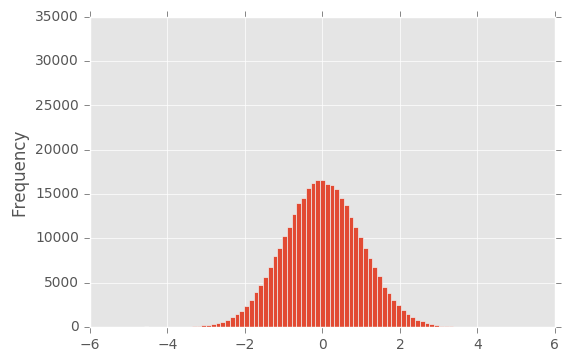

In [7]:
positivos = ceap[ceap.vlrLiquido > 0].vlrLiquido
aleatorios = pd.Series(np.random.randn(len(positivos)), name='normal')
aleatorios.plot.hist(bins=75, ylim=(0, 35000));

Observe que os valores de x = 0 são mais frequentes e a frequência diminui para as laterais. Você pode conferir mais detalhes sobre a [Distribuição Normal na Wikipedia](https://pt.wikipedia.org/wiki/Distribui%C3%A7%C3%A3o_normal).

Como é a distribuição dos valores da cota parlamentar?

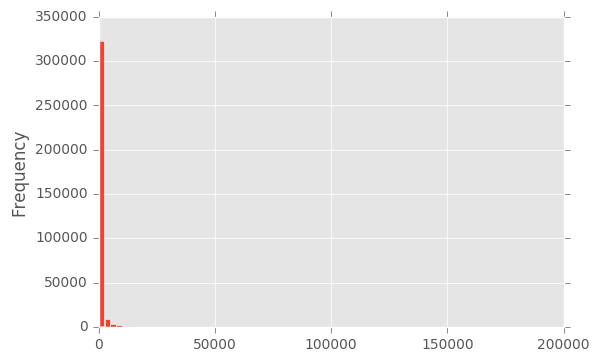

In [8]:
positivos.plot.hist(bins=75);

Bem diferente da distribuição normal padrão, não é? Embora invisíveis nessa escala, há alguns poucos gastos muito altos à direita. Além disso, notamos muitos gastos próximo do zero e uma diminuição brusca da barra ao lado.

Para que os valores se aproximem da normal, vamos transformá-los aplicando logaritmo, subtraindo a média e dividindo pelo desvio padrão. Vamos ver o resultado e a curva normal sobrepostos:

In [9]:
def log_zscores(valores):
    positivos = valores[valores > 0].dropna()
    logs = np.log(positivos)
    return (logs - logs.mean()) / logs.std()

vlrLiquido_z = log_zscores(positivos)

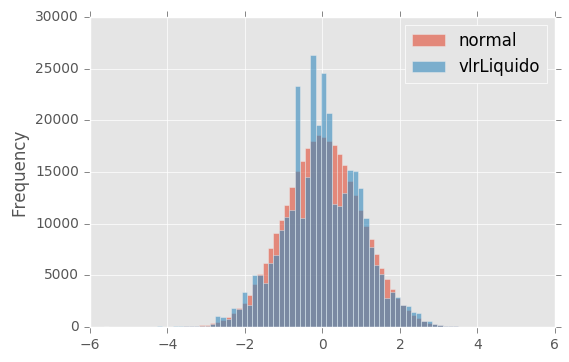

In [10]:
pd.concat([aleatorios, vlrLiquido_z], axis=1).plot.hist(bins=75, alpha=0.6);

Agora os gastos estão muito mais próximos da distribuição normal padrão. Segundo Andrew Ng, a distribuição não precisa ser muito igual à normal para obter bons resultados. Podemos seguir para o próximo passo: calcular a probabilidade da ocorrência de cada valor. Talvez você já tenha ouvido falar em "6 Sigma" ($6\sigma$) e esse nome vem do fato de que um intervalo entre $-3 \sigma$ e $3\sigma$ abrange quase 100% dos valores de uma distribuição normal. Na distribuição normal padrão, $\sigma = 1$.

Vamos então calcular a probabilidade de cada gasto, supondo que eles sigam uma distribuição normal e, em seguida, mostrar aqueles que possuem menor probabilidade de ocorrência (os 5 primeiros).

In [11]:
from scipy.stats import norm

def prob(valores):
    probs = valores.copy()
    probs[probs <= 0] = np.nan
    z = log_zscores(probs)
    probs[z.index] = norm.sf(z)
    return probs

ceap['prob_geral'] = prob(ceap.vlrLiquido)
colunas = ['prob_geral', 'vlrLiquido', 'txNomeParlamentar', 'sgPartido', 'sgUF', 'txtDescricao']
ceap[colunas].sort_values('prob_geral').head()

,prob_geral,vlrLiquido,txNomeParlamentar,sgPartido,sgUF,txtDescricao
32058,0.000014,189600.0,ARNALDO FARIA DE SÁ,PTB,SP,DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.
31751,0.000031,137900.0,ARLINDO CHINAGLIA,PT,SP,DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.
62020,0.000067,100000.0,CARLOS MANATO,SD,ES,DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.
125107,0.000067,100000.0,FÉLIX MENDONÇA JÚNIOR,PDT,BA,DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.
106736,0.000067,99900.0,ELCIONE BARBALHO,PMDB,PA,DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.


Os gastos com divulgação são os primeiros colocados. A tabela acima é a mesma que a última tabela da abordagem manual e sofre do mesmo problema: o catagoria com os maiores gastos é penalizada. Vamos corrigir isso a seguir.


### Valores por tipo de gasto
Vamos calcular as probabilidades da mesma maneira, mas considerando apenas os valores do mesmo grupo.

In [12]:
colunas = ['numSubCota', 'vlrLiquido']
ceap['prob_grupo'] = ceap[colunas].groupby('numSubCota').transform(prob)

colunas = ['prob_grupo', 'vlrLiquido', 'txNomeParlamentar', 'sgPartido', 'sgUF', 'txtDescricao']
ceap[colunas].sort_values('prob_grupo').head()

,prob_grupo,vlrLiquido,txNomeParlamentar,sgPartido,sgUF,txtDescricao
203398,3.347746e-09,6205.00,LIDERANÇA DO PT,NaN,NaN,FORNECIMENTO DE ALIMENTAÇÃO DO PARLAMENTAR
203401,1.356416e-08,5054.99,LIDERANÇA DO PT,NaN,NaN,FORNECIMENTO DE ALIMENTAÇÃO DO PARLAMENTAR
334220,2.165794e-08,56223.80,SUBTENENTE GONZAGA,PDT,MG,SERVIÇOS POSTAIS
245259,4.579753e-08,4200.00,MARLLOS SAMPAIO,PMDB,PI,FORNECIMENTO DE ALIMENTAÇÃO DO PARLAMENTAR
203402,4.732576e-08,4178.65,LIDERANÇA DO PT,NaN,NaN,FORNECIMENTO DE ALIMENTAÇÃO DO PARLAMENTAR


*NaN* significa que não há esse valor nos dados, mas é fácil entender o porquê pelo nome.

Na tabela acima, temos os gastos que mais destoam dentro de suas categorias. Entre os 5 primeiros, 4 são para cobrir alimentação e são cerca de 10 vezes menor que o gasto com serviços postais. Para se ter uma ideia do quanto eles se destacam em suas categorias, vamos ver o valor com alimentação abaixo do qual se encontram 99,865% dos gastos ($3 \sigma$ segundo a tabela que pode ser encontrada na [Wikipedia](https://en.wikipedia.org/wiki/Standard_normal_table)):

In [13]:
alim = ceap.query('numSubCota == 13 and vlrLiquido > 0').vlrLiquido.dropna()
alim_log = np.log(alim)
média_log = alim_log.mean()
sigma_log = alim_log.std()
limite_log = média_log + 3 * sigma_log

limite = np.exp(limite_log)
print('Valor limite = R$ {:.2f}:'.format(limite))
valores_abaixo = len(alim[alim < limite])
valores_totais = len(alim)
print('{} valores abaixo, em um total de {} = {:.3f}%.'.format(
        valores_abaixo, valores_totais, 100 * valores_abaixo/valores_totais))

Valor limite = R$ 564.93:
33388 valores abaixo, em um total de 33491 = 99.692%.


A porcentagem está bem próxima da teórica. Mais de 99% dos gastos com alimentação está abaixo de R\$ 564,93 e não é à toa que os gastos entre 4 e 6 mil estão entre os 5 primeiros da tabela acima. Marllos Sampaio, por exemplo, faz parte dos cerca de 0,3\% que mais gastaram com alimentação.

Por outro lado, pode ser mais interessante investigar o gasto com serviços postais, pois é cerca de 10 vezes maior que os gastos com alimentação. Como podemos destacar os gastos de maior valor aproveitando essa análise dentro de cada categoria? É o que vamos ver a seguir.

### Unindo as duas probablilidades

Primeiro, destacamos os maiores valores, mas acabamos priorizando categorias de gastos mais caras. Em seguida, destacamos os maiores valores dentro de cada categoria, mas obtivemos valores relativamente baixos. O ideal seria um balanço entre essas duas abordagens. Lembre-se do ensino médio (colegial, pros mais "experientes" :)) que a probabilidade de ocorrer $x$ e $y$ é igual a $P(x) \times P(y)$.

Vamos multiplicar as probabilidades, ordená-las e listas as primeiras:

In [14]:
ceap['prob_total'] = ceap.prob_geral * ceap.prob_grupo
colunas = ['prob_total', 'vlrLiquido', 'txNomeParlamentar', 'sgPartido', 'sgUF', 'txtDescricao']
ceap[colunas].sort_values('prob_total').head(10)

,prob_total,vlrLiquido,txNomeParlamentar,sgPartido,sgUF,txtDescricao
334220,5.376728e-12,56223.80,SUBTENENTE GONZAGA,PDT,MG,SERVIÇOS POSTAIS
203398,4.776580e-11,6205.00,LIDERANÇA DO PT,NaN,NaN,FORNECIMENTO DE ALIMENTAÇÃO DO PARLAMENTAR
261677,1.022311e-10,46988.80,NEWTON CARDOSO JR,PMDB,MG,PASSAGENS AÉREAS
203401,2.610402e-10,5054.99,LIDERANÇA DO PT,NaN,NaN,FORNECIMENTO DE ALIMENTAÇÃO DO PARLAMENTAR
271806,5.512234e-10,26383.80,PADRE JOÃO,PT,MG,SERVIÇOS POSTAIS
143969,5.640565e-10,26279.10,HEITOR SCHUCH,PSB,RS,SERVIÇOS POSTAIS
198259,6.029688e-10,25977.60,LELO COIMBRA,PMDB,ES,SERVIÇOS POSTAIS
245259,1.142396e-09,4200.00,MARLLOS SAMPAIO,PMDB,PI,FORNECIMENTO DE ALIMENTAÇÃO DO PARLAMENTAR
203402,1.188794e-09,4178.65,LIDERANÇA DO PT,NaN,NaN,FORNECIMENTO DE ALIMENTAÇÃO DO PARLAMENTAR
271805,1.254650e-09,22854.40,PADRE JOÃO,PT,MG,SERVIÇOS POSTAIS


Note que agora valores maiores e menores se intercalam dependendo do resultado da multiplicação das probabilidades, resolvendo nossos problemas em adotar apenas uma delas.


## O que fazer agora?

A tabela final completa, com todas as linhas e colunas, encontra-se em `dados/ceap2015resultado.csv.zip`. Com ela, você poderá ver o fornecedor, passageiro da passagem aérea, etc. O [site da Câmara](http://www.camara.gov.br/cota-parlamentar/site) da Câmara também disponibiliza algumas notas fiscais dos serviços prestados. Os serviços que não possuem nota estão especificados no item 7 da página de [Assessoria de Imprensa](http://www2.camara.leg.br/comunicacao/assessoria-de-imprensa/cota-parlamentar). Você também pode baixar este *notebook*, alterar o código e investigar os dados da sua maneira. Compartilhe o que encontrar de interessante!